In [63]:
%matplotlib inline

import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms
import os

In [131]:
from torchvision import datasets
import torchvision.transforms as transforms

batch_size = 64

# transforms
transform = transforms.ToTensor()

# train and validation data
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

val_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# training and validation data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size,
                                            shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = batch_size,
                                            shuffle = False)

In [132]:
import torch.nn as nn
import torch.nn.functional as F

# define a simple linear VAE
class LinearVAE(nn.Module):
    def __init__(self, input_size, hidden_dims):
        super(LinearVAE, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(input_size, hidden_dims*4)
        self.enc2 = nn.Linear(hidden_dims*4, hidden_dims*2)
 
        # decoder 
        self.dec1 = nn.Linear(hidden_dims, hidden_dims*4)
        self.dec2 = nn.Linear(hidden_dims*4, input_size)

    def reparameterize(self, mu, log_var):
        """
        :param mu: mean from the encoder's latent space
        :param log_var: log variance from the encoder's latent space
        """
        std = torch.exp(0.5 * log_var) # standard deviation
        eps = torch.randn_like(std) # `randn_like` as we need the same size
        sample = mu + (eps * std) # sampling as if coming from the input space
        return sample
 
    def forward(self, x):
        # encoding
        x = F.leaky_relu(self.enc1(x), 0.2)
        x = self.enc2(x).view(-1, 2, hidden_dims)
        # get `mu` and `log_var`
        mu = x[:, 0, :] # the first feature values as mean
        log_var = x[:, 1, :] # the other feature values as variance
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
 
        # decoding
        x = F.leaky_relu(self.dec1(z), 0.2)
        reconstruction = torch.sigmoid(self.dec2(x))
        return reconstruction, mu, log_var

In [133]:
input_size = 784
hidden_dims = 64

In [134]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lvae = LinearVAE(input_size, hidden_dims).to(device)
print(lvae)

LinearVAE(
  (enc1): Linear(in_features=784, out_features=256, bias=True)
  (enc2): Linear(in_features=256, out_features=128, bias=True)
  (dec1): Linear(in_features=64, out_features=256, bias=True)
  (dec2): Linear(in_features=256, out_features=784, bias=True)
)


In [135]:
import torch.optim as optim

lr = 0.0002

lvae_optimizer = optim.Adam(lvae.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

In [136]:
def final_loss(bce_loss, mu, logvar):
    """
    This function will add the reconstruction loss (BCELoss) and the 
    KL-Divergence.
    KL-Divergence = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    :param bce_loss: recontruction loss
    :param mu: the mean from the latent vector
    :param logvar: log variance from the latent vector
    """
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [137]:
def train(lvae, train_loader):
    lvae.train()
    running_loss = 0.0
    for batch_i, (data, _) in enumerate(train_loader):
        data = data.to(device)
        data = data.view(data.size(0), -1)
        lvae_optimizer.zero_grad()
        reconstruction, mu, logvar = lvae(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        running_loss += loss.item()
        loss.backward()
        lvae_optimizer.step()
    train_loss = running_loss/len(train_loader.dataset)
    return train_loss

In [138]:
from torchvision.utils import save_image
import pickle as pkl
samples = []

def validate(lvae, val_loader):
    lvae.eval()
    running_loss = 0.0
    with torch.no_grad():
        for batch_i, (data, _) in enumerate(val_loader):
            data = data.to(device)
            data = data.view(data.size(0), -1)
            reconstruction, mu, logvar = lvae(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if batch_i == len(val_data)//val_loader.batch_size - 1:
                num_rows = 8
                both = torch.cat((data.view(batch_size, 1, 28, 28)[:16], 
                                  reconstruction.view(batch_size, 1, 28, 28)[:16]))
                samples.append(both)
                save_image(both.cpu(), f"D:/NIRS/outputs/output{epoch+1}.png", nrow = num_rows)
    val_loss = running_loss/len(val_loader.dataset)
    return val_loss

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive/')

Mounted at /content/drive/


In [139]:
train_loss = []
val_loss = []

num_epochs = 20

for epoch in range(num_epochs):
    train_epoch_loss = train(lvae, train_loader)
    val_epoch_loss = validate(lvae, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print('Epoch [{:3d}/{:3d}] | train_loss: {:6.4f} | val_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, train_epoch_loss, val_epoch_loss))
    
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [  1/ 20] | train_loss: 209.7514 | val_loss: 166.2203
Epoch [  2/ 20] | train_loss: 157.0490 | val_loss: 147.6650
Epoch [  3/ 20] | train_loss: 142.4737 | val_loss: 136.5610
Epoch [  4/ 20] | train_loss: 134.1193 | val_loss: 129.6060
Epoch [  5/ 20] | train_loss: 128.3129 | val_loss: 124.8237
Epoch [  6/ 20] | train_loss: 124.0018 | val_loss: 120.9534
Epoch [  7/ 20] | train_loss: 120.8106 | val_loss: 118.4870
Epoch [  8/ 20] | train_loss: 118.5658 | val_loss: 116.4816
Epoch [  9/ 20] | train_loss: 116.8610 | val_loss: 115.0926
Epoch [ 10/ 20] | train_loss: 115.4993 | val_loss: 114.0144
Epoch [ 11/ 20] | train_loss: 114.4428 | val_loss: 112.9632
Epoch [ 12/ 20] | train_loss: 113.4618 | val_loss: 112.0395
Epoch [ 13/ 20] | train_loss: 112.7511 | val_loss: 111.4181
Epoch [ 14/ 20] | train_loss: 112.0504 | val_loss: 111.0054
Epoch [ 15/ 20] | train_loss: 111.4693 | val_loss: 110.3033
Epoch [ 16/ 20] | train_loss: 110.9702 | val_loss: 109.7926
Epoch [ 17/ 20] | train_loss: 110.5127 |

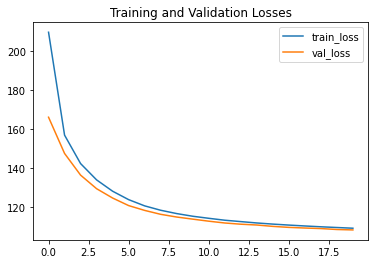

In [140]:
# Plot Training and Validation Loss of VAE vs. Epochs
fig, ax = plt.subplots()
train_loss = np.array(train_loss)
val_loss = np.array(val_loss)
plt.plot(train_loss.T, label='train_loss')
plt.plot(val_loss.T, label='val_loss')
plt.title("Training and Validation Losses")
plt.legend()

In [141]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(28,5), nrows = 2, ncols = 16, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [142]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

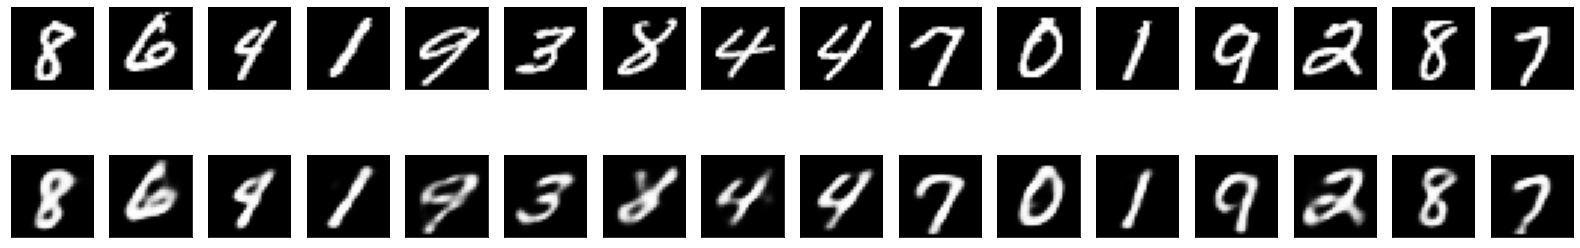

In [143]:
view_samples(-1, samples)